In [1]:
%pip install -U -q 'google-generativeai>=0.8.3'


Note: you may need to restart the kernel to use updated packages.


In [3]:
import google.generativeai as genai


In [4]:
from kaggle_secrets import UserSecretsClient

GOOGLE_API_KEY = UserSecretsClient().get_secret("GOOGLE_API_KEY")
genai.configure(api_key=GOOGLE_API_KEY)

In [6]:
for model in genai.list_models():
    if "createTunedModel" in model.supported_generation_methods:
        print(model.name)

models/gemini-1.0-pro-001
models/gemini-1.5-flash-001-tuning


In [ ]:
Download the dataset¶
In this activity, you will use the same newsgroups dataset that you used to train a classifier in Keras. In this example you will use a fine-tuned Gemini model to achieve the same goal.

In [7]:
from sklearn.datasets import fetch_20newsgroups

newsgroups_train = fetch_20newsgroups(subset="train")
newsgroups_test = fetch_20newsgroups(subset="test")

# View list of class names for dataset
newsgroups_train.target_names

['alt.atheism',
 'comp.graphics',
 'comp.os.ms-windows.misc',
 'comp.sys.ibm.pc.hardware',
 'comp.sys.mac.hardware',
 'comp.windows.x',
 'misc.forsale',
 'rec.autos',
 'rec.motorcycles',
 'rec.sport.baseball',
 'rec.sport.hockey',
 'sci.crypt',
 'sci.electronics',
 'sci.med',
 'sci.space',
 'soc.religion.christian',
 'talk.politics.guns',
 'talk.politics.mideast',
 'talk.politics.misc',
 'talk.religion.misc']

In [8]:
print(newsgroups_train.data[0])

From: lerxst@wam.umd.edu (where's my thing)
Subject: WHAT car is this!?
Nntp-Posting-Host: rac3.wam.umd.edu
Organization: University of Maryland, College Park
Lines: 15

 I was wondering if anyone out there could enlighten me on this car I saw
the other day. It was a 2-door sports car, looked to be from the late 60s/
early 70s. It was called a Bricklin. The doors were really small. In addition,
the front bumper was separate from the rest of the body. This is 
all I know. If anyone can tellme a model name, engine specs, years
of production, where this car is made, history, or whatever info you
have on this funky looking car, please e-mail.

Thanks,
- IL
   ---- brought to you by your neighborhood Lerxst ----







In [ ]:
Prepare the dataset¶
You'll use the same pre-processing code you used for the custom model on day 2. This pre-processing removes personal information, which can be used to "shortcut" to known users of a forum, and formats the text to appear a bit more like regular text and less like a newsgroup post (e.g. by removing the mail headers). This normalisation allows the model to generalise to regular text and not over-depend on specific fields. If your input data is always going to be newsgroup posts, it may be helpful to leave this structure in place if they provide genuine signals.

In [10]:
import email
import re

import pandas as pd


def preprocess_newsgroup_row(data):
    # Extract only the subject and body
    msg = email.message_from_string(data)
    text = f"{msg['Subject']}\n\n{msg.get_payload()}"
    # Strip any remaining email addresses
    text = re.sub(r"[\w\.-]+@[\w\.-]+", "", text)
    # Truncate the text to fit within the input limits
    text = text[:40000]

    return text


def preprocess_newsgroup_data(newsgroup_dataset):
    # Put data points into dataframe
    df = pd.DataFrame(
        {"Text": newsgroup_dataset.data, "Label": newsgroup_dataset.target}
    )
    # Clean up the text
    df["Text"] = df["Text"].apply(preprocess_newsgroup_row)
    # Match label to target name index
    df["Class Name"] = df["Label"].map(lambda l: newsgroup_dataset.target_names[l])

    return df

In [11]:
# Apply preprocessing to training and test datasets
df_train = preprocess_newsgroup_data(newsgroups_train)
df_test = preprocess_newsgroup_data(newsgroups_test)

df_train.head()

,Text,Label,Class Name
0,WHAT car is this!?\n\n I was wondering if anyo...,7,rec.autos
1,SI Clock Poll - Final Call\n\nA fair number of...,4,comp.sys.mac.hardware
2,"PB questions...\n\nwell folks, my mac plus fin...",4,comp.sys.mac.hardware
3,Re: Weitek P9000 ?\n\nRobert J.C. Kyanko () wr...,1,comp.graphics
4,Re: Shuttle Launch Question\n\nFrom article <>...,14,sci.space


In [12]:
def sample_data(df, num_samples, classes_to_keep):
    # Sample rows, selecting num_samples of each Label.
    df = (
        df.groupby("Label")[df.columns]
        .apply(lambda x: x.sample(num_samples))
        .reset_index(drop=True)
    )

    df = df[df["Class Name"].str.contains(classes_to_keep)]
    df["Class Name"] = df["Class Name"].astype("category")

    return df


TRAIN_NUM_SAMPLES = 50
TEST_NUM_SAMPLES = 10
# Keep rec.* and sci.*
CLASSES_TO_KEEP = "^rec|^sci"

df_train = sample_data(df_train, TRAIN_NUM_SAMPLES, CLASSES_TO_KEEP)
df_test = sample_data(df_test, TEST_NUM_SAMPLES, CLASSES_TO_KEEP)

In [ ]:
Evaluate baseline performance¶
Before you start tuning a model, it's good practice to perform an evaluation on the available models to ensure you can measure how much the tuning helps.

First identify a single sample row to use for visual inspection.

In [13]:
sample_idx = 0
sample_row = preprocess_newsgroup_row(newsgroups_test.data[sample_idx])
sample_label = newsgroups_test.target_names[newsgroups_test.target[sample_idx]]

print(sample_row)
print('---')
print('Label:', sample_label)

Need info on 88-89 Bonneville


 I am a little confused on all of the models of the 88-89 bonnevilles.
I have heard of the LE SE LSE SSE SSEI. Could someone tell me the
differences are far as features or performance. I am also curious to
know what the book value is for prefereably the 89 model. And how much
less than book value can you usually get them for. In other words how
much are they in demand this time of year. I have heard that the mid-spring
early summer is the best time to buy.

			Neil Gandler

---
Label: rec.autos


In [14]:
baseline_model = genai.GenerativeModel("gemini-1.5-flash-001")
response = baseline_model.generate_content(sample_row)
print(response.text)

You're right, there were a lot of Bonneville trim levels in 1988 and 1989, and it can be confusing! Here's a breakdown:

**1988-1989 Pontiac Bonneville Trim Levels**

* **LE:** The base model, offering basic features and a 3.8L V6 engine.
* **SE:**  Added some luxury features, including power accessories and possibly a 3.8L V6 or a 5.0L V8 engine option.
* **LSE:**  Introduced in 1989. This trim level had the same engine options as the SE but included additional features like a sunroof, leather seats, and upgraded interior trim.
* **SSE:**  Also introduced in 1989, this was the sporty version with a standard 5.0L V8 engine, a sport-tuned suspension, and unique styling cues.
* **SSEi:** The top-of-the-line model, also available in 1989. This trim offered the same engine and suspension as the SSE, but added a digital instrument cluster, upgraded interior materials, and even more styling features like a unique grille.

**Book Value and Market Demand**

The book value of a 1989 Bonneville 

In [15]:
# Ask the model directly in a zero-shot prompt.

prompt = "From what newsgroup does the following message originate?"
baseline_response = baseline_model.generate_content([prompt, sample_row])
print(baseline_response.text)

Based on the content of the message, it most likely originated from a **newsgroup dedicated to Pontiac Bonnevilles or classic cars in general**. 

Here's why:

* **Specific car model:** The message focuses on the 1988-1989 Bonneville, indicating a specific car model interest.
* **Model variations:** The message mentions different trim levels like LE, SE, LSE, SSE, and SSEi, suggesting a community with detailed knowledge of Bonneville models. 
* **Book value and pricing:** The inquiries about book value and market pricing are typical in car-related forums or newsgroups.
* **Seasonal buying trends:** The mention of "mid-spring early summer" as a good time to buy is common in car buying discussions.

While there isn't enough information to pinpoint the exact newsgroup, possibilities include:

* **alt.autos.pontiac**
* **rec.autos.makers.pontiac**
* **rec.autos.marketplace**
* **alt.autos.used**

It's also possible the message came from a more general car forum or newsgroup. 



In [16]:
from google.api_core import retry

# You can use a system instruction to do more direct prompting, and get a
# more succinct answer.

system_instruct = """
You are a classification service. You will be passed input that represents
a newsgroup post and you must respond with the newsgroup from which the post
originates.
"""

instructed_model = genai.GenerativeModel("gemini-1.5-flash-001",
                                         system_instruction=system_instruct)

retry_policy = {"retry": retry.Retry(predicate=retry.if_transient_error)}

# If you want to evaluate your own technique, replace this function with your
# model, prompt and other code and return the predicted answer.
def predict_label(post: str) -> str:
    response = instructed_model.generate_content(post, request_options=retry_policy)
    rc = response.candidates[0]

    # Any errors, filters, recitation, etc we can mark as a general error
    if rc.finish_reason.name != "STOP":
        return "(error)"
    else:
        # Clean up the response.
        return response.text.strip()


prediction = predict_label(sample_row)

print(prediction)
print()
print("Correct!" if prediction == sample_label else "Incorrect.")

rec.autos.misc

Incorrect.


In [ ]:
Now run a short evaluation using the function defined above. The test set is further sampled to ensure the experiment runs smoothly on the API's free tier. In practice you would evaluate over the whole set.

In [17]:
from tqdm.rich import tqdm

tqdm.pandas()


# Further sample the test data to be mindful of the free-tier quota.
df_baseline_eval = sample_data(df_test, 2, '.*')

# Make predictions using the sampled data.
df_baseline_eval['Prediction'] = df_baseline_eval['Text'].progress_apply(predict_label)

# And calculate the accuracy.
accuracy = (df_baseline_eval["Class Name"] == df_baseline_eval["Prediction"]).sum() / len(df_baseline_eval)
print(f"Accuracy: {accuracy:.2%}")

 100% ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 16/16  [ 0:00:07 < 0:00:00 , 2 it/s ]

Accuracy: 31.25%


In [18]:
df_baseline_eval #looking at the dataframe

,Text,Label,Class Name,Prediction
0,REVIEW: Audi S4 quattro\n\nIt's been a while s...,7,rec.autos,rec.autos.misc
1,Re: comparing saabs & bmw's\n\nIn article <> ...,7,rec.autos,rec.autos.bmw
2,Volvo Attack!\n\nI was privelged enough to exp...,8,rec.motorcycles,rec.motorcycles
3,Assorted Ranting\n\n\n \n Grr. Hate the bastar...,8,rec.motorcycles,rec.motorcycles
4,Re: Jack Morris\n\nIn article <> (Roger Mayna...,9,rec.sport.baseball,rec.sports.baseball
5,Re: Opinions on Eli & Denny Show\n\nSo THAT'S ...,9,rec.sport.baseball,talk.politics.misc
6,Re: SHARKS: Jack Feirerra (was Re: SHARKS: Kin...,10,rec.sport.hockey,rec.sports.hockey
7,BLUES: Playoff stats through first round\n\nBL...,10,rec.sport.hockey,rec.sport.hockey
8,"Re: Once tapped, your code is no good any more...",11,sci.crypt,(error)
9,"Re: Once tapped, your code is no good any more...",11,sci.crypt,(error)


In [ ]:
Tune a custom model¶
In this example you'll use tuning to help create a model that requires no prompting or system instructions and outputs succinct text from the classes you provide in the training data.

The data contains both input text (the processed posts) and output text (the category, or newsgroup), which you can use to start tuning a model.

The Python SDK for tuning supports Pandas dataframes as input, so you don't need any custom data generators or pipelines. Just specify the input and the relevant columns as the input_key and output_key.

When calling create_tuned_model, you can specify model tuning hyperparameters too:

epoch_count: defines how many times to loop through the data,
batch_size: defines how many rows to process in a single step, and
learning_rate: defines the scaling factor for updating model weights at each step.

In [19]:
from collections.abc import Iterable
import random


# Append a random number to the model ID so you can re-run with a higher chance
# of creating a unique model ID.
model_id = f"newsgroup-classifier-{random.randint(10000, 99999)}"

# Upload the training data and queue the tuning job.
tuning_op = genai.create_tuned_model(
    "models/gemini-1.5-flash-001-tuning",
    training_data=df_train,
    input_key="Text",  # the column to use as input
    output_key="Class Name",  # the column to use as output
    id=model_id,
    display_name="Newsgroup classification model",
    batch_size=16,
    epoch_count=2,
)

print(model_id)

newsgroup-classifier-64890


State.CREATING
State.CREATING
State.CREATING
State.CREATING
State.CREATING
Done! The model is ACTIVE


/opt/conda/lib/python3.10/site-packages/seaborn/_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):
/opt/conda/lib/python3.10/site-packages/seaborn/_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):


<Axes: xlabel='step', ylabel='mean_loss'>

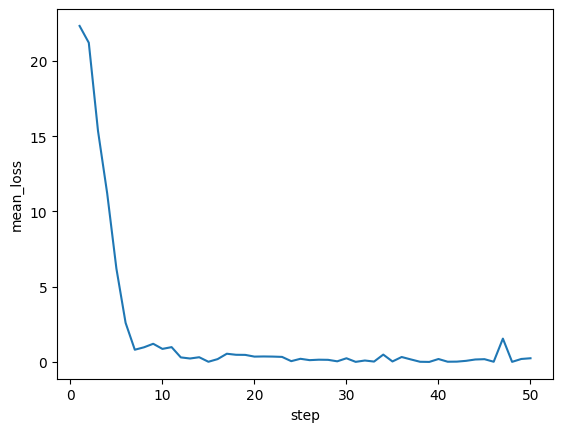

In [20]:
import time
import seaborn as sns


while (tuned_model := genai.get_tuned_model(f"tunedModels/{model_id}")).state.name != 'ACTIVE':

    print(tuned_model.state)
    time.sleep(60)

print(f"Done! The model is {tuned_model.state.name}")

# Plot the loss curve.
snapshots = pd.DataFrame(tuned_model.tuning_task.snapshots)
sns.lineplot(data=snapshots, x="step", y="mean_loss")

In [ ]:
Use the new model¶
Now that you have a tuned model, try it out with custom data. You use the same API as a normal Gemini API interaction, but you specify your new model as the model name, using the tunedModels/ prefix.

In [21]:
your_model = genai.GenerativeModel(f"tunedModels/{model_id}")

new_text = """
First-timer looking to get out of here.

Hi, I'm writing about my interest in travelling to the outer limits!

What kind of craft can I buy? What is easiest to access from this 3rd rock?

Let me know how to do that please.
"""

response = your_model.generate_content(new_text)
print(response.text)

sci.space


In [22]:
your_model = genai.GenerativeModel(f"tunedModels/{model_id}")

new_text = """
First-timer looking to get out of here.

Hi, I'm writing about my interest in travelling to the outer limits!

What kind of craft can I buy? What is easiest to access from this 3rd rock?

Let me know how to do that please.
"""

response = your_model.generate_content(new_text)
print(response.text)

sci.space


In [ ]:
Evaluation¶
You can see that the model outputs labels that correspond to those in the training data, and without any system instructions or prompting, which is already a great improvement. Now see how well it performs on the test set.

Note that there is no parallelism in this example; classifying the test sub-set will take a few minutes.

In [23]:
def classify_text(text: str) -> str:
    """Classify the provided text into a known newsgroup."""
    response = your_model.generate_content(text, request_options=retry_policy)
    rc = response.candidates[0]

    # Any errors, filters, recitation, etc we can mark as a general error
    if rc.finish_reason.name != "STOP":
        return "(error)"
    else:
        return rc.content.parts[0].text


# The sampling here is just to minimise your quota usage. If you can, you should
# evaluate the whole test set with `df_model_eval = df_test.copy()`.
df_model_eval = sample_data(df_test, 4, '.*')


df_model_eval["Prediction"] = df_model_eval["Text"].progress_apply(classify_text)

accuracy = (df_model_eval["Class Name"] == df_model_eval["Prediction"]).sum() / len(df_model_eval)
print(f"Accuracy: {accuracy:.2%}")

 100% ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 32/32  [ 0:01:29 < 0:00:00 , 1 it/s ]

Accuracy: 93.75%


In [ ]:
Compare token usage¶
AI Studio and the Gemini API provide model tuning at no cost, however normal limits and charges apply for use of a tuned model.

The size of the input prompt and other generation config like system instructions, as well as the number of generated output tokens, all contribute to the overall cost of a request.

In [24]:
# Calculate the *input* cost of the baseline model with system instructions.
sysint_tokens = instructed_model.count_tokens(sample_row).total_tokens
print(f'System instructed baseline model: {sysint_tokens} (input)')

# Calculate the input cost of the tuned model.
tuned_tokens = your_model.count_tokens(sample_row).total_tokens
print(f'Tuned model: {tuned_tokens} (input)')

savings = (sysint_tokens - tuned_tokens) / tuned_tokens
print(f'Token savings: {savings:.2%}')  # Note that this is only n=1.

System instructed baseline model: 171 (input)
Tuned model: 135 (input)
Token savings: 26.67%


In [25]:
baseline_token_output = baseline_response.usage_metadata.candidates_token_count
print('Baseline (verbose) output tokens:', baseline_token_output)

tuned_model_output = your_model.generate_content(sample_row)
tuned_tokens_output = tuned_model_output.usage_metadata.candidates_token_count
print('Tuned output tokens:', tuned_tokens_output)

Baseline (verbose) output tokens: 237
Tuned output tokens: 3
